<h1 style="background-color:rgb(67, 77, 86);
           font-size:300%;
           font-style: oblique;
           color:white;
           text-align:center;
           margin: auto;
           padding: 20px;">Predicting Bank Churners</h1>

<a id="1.2"></a>
<h2 style="background-color:rgb(141, 153, 165);
           font-size:250%;
           color:white;
           text-align:center;
           margin: auto;
           padding: 10px;">Chapter 4. Scaling</h2>

<a id='1.1'>
    <h2 style='font-size:180%;'>
        Mission</h2></a>

<figure>
    <blockquote cite='https://www.kaggle.com/sakshigoyal7/credit-card-customers/tasks?taskId=2729'>
        <p style='font-size:110%;
                  color:hsl(208, 12%, 30%);'><i>Our top priority in this business problem is to identify customers who are getting churned. Even if we predict non-churning customers as churned, it won't harm our business. But predicting churning customers as non-churning will do. So recall needs to be higher. Till now, I have managed to get a recall of 62%.</i></p>
    </blockquote>
    <figcaption>—Sakshi Goyal, <cite>Credit Card Customers, Kaggle</cite></figcaption>

<a id='4.1'>
    <h2 style='font-size:180%;'>
        Libraries</h2></a>

In [1]:
# general
import numpy as np
import pandas as pd
import random as rd
import copy

# data visualization
import matplotlib.pyplot as plt
from matplotlib import rcParams

# statistics
from scipy import stats
from scipy.stats import (
    pearsonr, spearmanr, kendalltau,
    chi2_contingency, f_oneway)

# machine learning prep
from sklearn.preprocessing import (
    MinMaxScaler, RobustScaler, QuantileTransformer, PowerTransformer)
from collections import Counter
from sklearn.model_selection import (
    train_test_split, cross_validate, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV)
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, fbeta_score, auc, roc_auc_score,
    precision_recall_curve, plot_precision_recall_curve, average_precision_score, precision_recall_fscore_support,
    classification_report, precision_recall_fscore_support, confusion_matrix, SCORERS)
from sklearn.pipeline import Pipeline

# machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import (SVC, LinearSVC) # remove SVC later if not used
from sklearn.ensemble import (GradientBoostingClassifier, RandomForestClassifier, IsolationForest)
from sklearn.neural_network import MLPClassifier

# warning
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

# saving
import os

# multiprocessing
import concurrent.futures
import time

# display settings
%matplotlib inline
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(suppress=True, precision=3)

In [2]:
%%html
<style>
/* CSS styles for pandas dataframe */
.dataframe th {
    font-size: 16px;
}
.dataframe td {
    font-size: 14px;
}
</style>

In [3]:
# pd.set_options('precision', 3)
# pd.set_options('min_rows', 6)
# pd.set_options('max_rows', 10)
# pd.reset_option('max_rows')
# pd.set_option('max_colwidth', 10)
# pd.set_option("chop_threshold", 0.5)
# pd.reset_option("chop_threshold")
# pd.set_option("colheader_justify", "left")
# pd.reset_option("colheader_justify")
# plt.rc('figure',figsize=(8,4))
# plt.style.use('seaborn-whitegrid')
# from IPython.display import display, Math, Latex
# pio.renderers.default='plotly_mimetype'

<a id='4.2'>
    <h2 style='font-size:180%;'>
        Data Loading</h2></a>

In [4]:
start_normal = time.perf_counter()

In [5]:
# load data
d = pd.read_csv('source/d_num.csv')
d.head(3)

,churn,age,gender,dependents,prod_ct,mo_on_book,mo_inactive_r12,contr_ct_r12,revbal_avg_r12,credlim_avg_r12,opentobuy_avg_r12,utilratio_avg,tx_amt_r12,tx_ct_r12,chng_tx_amt_q4_q1,chng_tx_ct_q4_q1,marstat_Divorced,marstat_Married,marstat_Single,marstat_Unknown,card_Blue,card_Gold,card_Platinum,card_Silver,educ,inc,tx_amt_pertx_r12
0,0,45,1,3,5,39,1,3,777.00,"12,691.00","11,914.00",0.06,"1,144.00",42,1.33,1.62,0,1,0,0,1,0,0,0,1,3,27.24
1,0,49,0,5,6,44,1,2,864.00,"8,256.00","7,392.00",0.10,"1,291.00",33,1.54,3.71,0,0,1,0,1,0,0,0,3,1,39.12
2,0,51,1,3,4,36,1,0,0.00,"3,418.00","3,418.00",0.00,"1,887.00",20,2.59,2.33,0,1,0,0,1,0,0,0,3,4,94.35


<a id='4.3'>
    <h2 style='font-size:180%;'>
        Train Test Split</h2></a>

In [6]:
d_values = d.values
x, y = d_values[:,1:], d_values[:,:1].ravel()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1, shuffle=True, stratify=y)

<a id="1.2"></a>
<h2 style="background-color:rgb(141, 153, 165);
           font-size:250%;
           color:white;
           text-align:center;
           margin: auto;
           padding: 10px;">Functions to Use</h2>

### Performance Metrics

In [7]:
def perf_metrics(y_test, y_pred):
    dic = {}
    dic['accuracy'] = round(accuracy_score(y_test, y_pred), 2)
    dic['precision'] = round(precision_score(y_test, y_pred), 2)
    dic['recall'] = round(recall_score(y_test, y_pred), 2)
    dic['f1'] = round(f1_score(y_test, y_pred), 2)
    dic['f2'] = round(fbeta_score(y_test, y_pred, beta=2), 2)
    return dic

### Result Summary

In [9]:
def result_rskf(x, y, pipeline, mod_disp_name, n_splits=5, n_repeats=3):
    scoring = {
        'accuracy':'accuracy', 'precision':'precision', 'recall':'recall', 'f1':'f1', 
        'f2':make_scorer(fbeta_score, beta=2)} # dict val = scorer fct or predefined metric str  
    cv = RepeatedStratifiedKFold(
        n_splits=n_splits, n_repeats=n_repeats, random_state=1)       
    result = cross_validate(
        pipeline, x, y, cv=cv, 
        scoring=scoring, return_train_score=True, n_jobs=-1)
        
    # make a summary table
    df = pd.DataFrame(
        (k, mean(v), std(v)) for k,v in result.items()
        ).rename({0:'metric', 1:'mean', 2:'std'}, axis=1
                ).set_index('metric')
    df.index.name = None
    df.columns = pd.MultiIndex.from_product([[mod_disp_name],df.columns])
    
    return df, result

In [11]:
def result_tts(x, y, pipeline, mod_disp_name):
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.2, random_state=1, shuffle=True, stratify=y)
    time_0 = time()
    pipeline.fit(x_train, y_train)
    time_1 = time()
    y_pred = pipeline.predict(x_test)
    time_2 = time()
    result = {}
    result['fit_time'] = round(time_1-time_0, 2)
    result['score_time'] = round(time_2-time_1, 2)
    result['accuracy'] = round(accuracy_score(y_test, y_pred), 2)
    result['precision'] = round(precision_score(y_test, y_pred), 2)
    result['recall'] = round(recall_score(y_test, y_pred), 2)
    result['f1'] = round(f1_score(y_test, y_pred), 2)
    result['f2'] = round(fbeta_score(y_test, y_pred, beta=2), 2)
    conf_mat = confusion_matrix(y_test, y_pred, labels=[1,0])
    df = pd.DataFrame(result, index=[mod_disp_name]).T
    return df, result, conf_mat, y_pred, y_test

In [24]:
def results_full(models, scaler, set_applied='validation'):
    
    """
    Function
    ----------
    Returns a summary DataFrame of models and performance metrics
    
    Parameters
    ----------
    models : list of tuples
        List of tuples of model name and the instantiation of the 
        corresponding model for all models of interest
    scaler : instantiation
        Instantiation of scaler of interest
    set_applied : str
        'validation' by default. The other option is 'test'. 
        Any other text besides 'validation' works as 'test'.
        
    Returns
    -------
    results_summary_df : DataFrame
        Summary DataFrame of all models and their performance metrics
    names : list
        List of model names
    results : list of dictionaries containing all performance metrics
        List of all performance metrics for each model
    """    
    
    # initiate results and scoring methods
    results, names = [], []
    scoring = ('accuracy', 'precision', 'recall', 'f1', 'roc_auc')
    
    # define pipeline for all the models to try
    for name, model in models:
        pipeline = Pipeline([
            ('scaler', scaler),
            ('m', model)])
        
        # apply on validation sets
        if set_applied=='validation':
            cv = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)        
            result = cross_validate(
                pipeline, x_train, y_train, cv=cv, 
                scoring=scoring, return_train_score=True, n_jobs=-1)
        
        # apply on test sets
        else:  
            pipeline.fit(x_train, y_train)
            y_pred = pipeline.predict(x_test)
            result = perf_metrics(y_test, y_pred)  
            
        names.append(name)
        results.append(result)    
    
    # make a summary table
    results_summary_df = pd.DataFrame()
    for i in np.arange(len(names)):
        results_metric, results_mean, results_std = [], [], []
        for k,v in results[i].items():
            results_metric.append(k)
            results_mean.append(np.round(np.mean(v),3))
            results_std.append(np.round(np.std(v),3))
            
        if set_applied=='validation':
            df = pd.DataFrame(
                    list(zip(results_metric, results_mean, results_std, [names[i] for ct in np.arange(len(results[0]))])), 
                    columns=['metric', 'mean', 'std', 'mod'])
            df = df.set_index(['mod','metric']).stack().unstack([1,2])
            results_summary_df = pd.concat([results_summary_df, df])
        else:
            df = pd.DataFrame(
                    list(zip(results_metric, results_mean, [names[i] for ct in np.arange(len(results[0]))])), 
                    columns=['metric', 'mean', 'mod'])
            df = df.set_index(['mod','metric']).stack().unstack([1,2]).droplevel(1, axis=1) 
            results_summary_df = pd.concat([results_summary_df, df])        
            
            
    return results_summary_df, names, results

<a id="1.2"></a>
<h2 style="background-color:rgb(141, 153, 165);
           font-size:250%;
           color:white;
           text-align:center;
           margin: auto;
           padding: 10px;">Benchmark</h2>

<a id='5.3.1'>
    <h2 style='font-size:210%;'>
        Comment on <code>MinMaxScaler()</code></h2></a>

The `MinMaxScaler()` transforms each feature individually by bounding the minimum and maximum values of each feature to a given range, usually `0` and `1`. If negative values exist, the scaler will bound the values to `-1` and `1`. This Scaler responds well if **the standard deviation is small** and when a **distribution is not Gaussian**. As this scaler is **sensitive to outliers**, it is important to treat outliers beforehand. We will see the effects of Outlier Treatment in a later section.

[All About Feature Scaling, *Towards Data Science*](https://towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35)<br>
[Standardize or Normalize Examples in Python, *Medium*](https://medium.com/@rrfd/standardize-or-normalize-examples-in-python-e3f174b65dfc)

<a id='4.2'>
    <h2 style='font-size:210%;'>
        Baseline Models</h2></a>

In [9]:
# create a list of tuples for all models to explore: [(`model name`, `model instance`)] with minimum hyperparameter setting
models = []

# linear
models.append(('LR', LogisticRegression(solver='saga', max_iter=10000, class_weight='balanced', random_state=5))) # note: `max_iter` from 1000 to 10000 due to convergence issues
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('NB', GaussianNB()))

# non-linear
models.append(('DT', DecisionTreeClassifier(random_state=5)))
models.append(('KNN', KNeighborsClassifier(n_neighbors=5)))
models.append(('MLP', MLPClassifier(max_iter=1000, random_state=5)))

# ensemble
models.append(('BDT', BaggingClassifier(n_estimators=50, n_jobs=-1, random_state=5)))
models.append(('RF', RandomForestClassifier(n_estimators=50, max_depth=10, n_jobs=-1, random_state=5))) # note: increasing n_estimators more than 400 doesn't do much; some in place to prevent too much overfitting
models.append(('GB', GradientBoostingClassifier(random_state=5))) # note: `max_iter` from 100 to 1000 due to convergence issues

In [10]:
# create an instance of scaler to use
scaler = MinMaxScaler()

<a id='4.2'>
    <h2 style='font-size:180%;'>
        Validation Set</h2></a>

In [11]:
r_baseline_validation = results_full(models, scaler, set_applied='validation')

In [12]:
r_baseline_validation[0]

metric fit_time      score_time      test_accuracy      train_accuracy       \
           mean  std       mean  std          mean  std           mean  std   
mod                                                                           
LR         0.17 0.02       0.02 0.00          0.86 0.01           0.86 0.00   
LDA        0.05 0.01       0.01 0.00          0.91 0.01           0.91 0.00   
KNN        0.01 0.00       0.94 0.04          0.89 0.00           0.93 0.00   
RF         5.60 0.68       1.13 0.32          0.96 0.00           0.99 0.00   
NB         0.02 0.00       0.02 0.00          0.90 0.01           0.90 0.00   
GB         4.04 0.08       0.03 0.00          0.96 0.00           0.97 0.00   
MLP       36.08 6.03       0.02 0.00          0.94 0.01           0.96 0.01   

metric test_precision      train_precision      test_recall      train_recall  \
                 mean  std            mean  std        mean  std         mean   
mod                                                                             
LR               0.54 0.02            0.54 0.00        0.86 0.02         0.86   
LDA              0.77 0.02            0.78 0.01        0.62 0.04         0.63   
KNN              0.72 0.03            0.89 0.00        0.48 0.02         0.67   
RF               0.92 0.02            0.99 0.00        0.80 0.03         0.94   
NB               0.71 0.03            0.71 0.01        0.59 0.04         0.59   
GB               0.93 0.01            0.96 0.00        0.83 0.03         0.89   
MLP              0.84 0.02            0.92 0.02        0.78 0.04         0.86   

metric      test_f1      train_f1      test_roc_auc      train_roc_auc       
        std    mean  std     mean  std         mean  std          mean  std  
mod                                                                          
LR     0.00    0.66 0.01     0.66 0.00         0.93 0.01          0.93 0.00  
LDA    0.01    0.69 0.03     0.70 0.01         0.93 0.01          0.93 0.00  
KNN    0.01    0.58 0.02     0.76 0.01         0.82 0.01          0.97 0.00  
RF     0.01    0.85 0.01     0.96 0.00         0.99 0.00          1.00 0.00  
NB     0.02    0.64 0.03     0.64 0.01         0.87 0.01          0.88 0.00  
GB     0.00    0.88 0.01     0.92 0.00         0.99 0.00          0.99 0.00  
MLP    0.03    0.81 0.02     0.89 0.02         0.97 0.00          0.99 0.00

In [13]:
r_baseline_validation[0][['test_recall', 'train_recall']]

metric test_recall      train_recall     
              mean  std         mean  std
mod                                      
LR            0.86 0.02         0.86 0.00
LDA           0.62 0.04         0.63 0.01
KNN           0.48 0.02         0.67 0.01
RF            0.80 0.03         0.94 0.01
NB            0.59 0.04         0.59 0.02
GB            0.83 0.03         0.89 0.00
MLP           0.78 0.04         0.86 0.03

<a id='4.2'>
    <h2 style='font-size:180%;'>
        Test Set</h2></a>

Gradient Boost and MLP on the test set saw some significant improvements compared to the those on the validation set due to informational gain. This makes sense because these models tend to be more sensitive to data size, and the validation set only uses 80% of the data (train set).

In [25]:
r_baseline_test = results_full(models, scaler, set_applied='test')

In [26]:
r_baseline_test[0]

metric,accuracy,precision,recall,f1,f2
mod,,,,,
LR,0.85,0.52,0.89,0.66,0.78
LDA,0.92,0.79,0.67,0.72,0.69
KNN,0.88,0.71,0.46,0.56,0.50
RF,0.96,0.93,0.84,0.88,0.85
NB,0.89,0.71,0.57,0.63,0.59
GB,0.97,0.93,0.90,0.91,0.90
MLP,0.95,0.86,0.83,0.85,0.84


In [27]:
r_baseline_test[0][['precision','recall','f2']]

metric,precision,recall,f2
mod,,,
LR,0.52,0.89,0.78
LDA,0.79,0.67,0.69
KNN,0.71,0.46,0.50
RF,0.93,0.84,0.85
NB,0.71,0.57,0.59
GB,0.93,0.90,0.90
MLP,0.86,0.83,0.84


<a id='4.2'>
    <h2 style='font-size:180%;'>
        Compare Algorithm</h2></a>

We see some promising signs in Logistic Regression (`LR`), Random Forest (`RF`), Gradient Boost (`GB`), and Multilayer Perceptron (`MLP`) from the validation set.

In [17]:
names, results = r_baseline_validation[1], r_baseline_validation[2]

In [ ]:
# plot the precision-recall curves
plt.figure(figsize=(12,9))
plt.style.use('seaborn-darkgrid')

no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], label='No Skill', 
         marker='', linewidth=4, alpha=0.7, color='yellow')


scaler = QuantileTransformer()

# fit a model
for i in np.arange(len(models)):
    model = models[i][1]
    pipeline = Pipeline([('s', scaler),('m',model)])
    pipeline.fit(x_train, y_train)
    
    # predict using test set
    y_hat = pipeline.predict(x_test) # predict class values
    y_hat_prob = pipeline.predict_proba(x_test)[:, 1] # predict probabilities; indexing added to retrieve just the probabilities for the positive class
    
    # print out the metrics for each model
    precision, recall, f2, support = precision_recall_fscore_support(y_test, y_hat)
    print('%s:   Precision: %.2f%%  Recall: %.2f%%  F-2: %.2f%%  Support: %.0f' % (
    models[i][0], precision[1]*100, recall[1]*100, f2[1]*100, support[1]))

    # compute precision-recall pairs for different probability thresholds & plot the results
    precision_t, recall_t, _ = precision_recall_curve(y_test, y_hat_prob)
    plt.plot(recall_t, precision_t, label=models[i][0],
            marker='', linewidth=4, alpha=0.7)
        
# axis labels
plt.xlabel('Recall', fontsize=18)
plt.ylabel('Precision', fontsize=18)

# show the legend
plt.legend(loc = (0.15,0.25), fontsize=14)
plt.title('2-Class Precision-Recall Curve',
         fontsize=18, fontweight=2)

# show the plot
plt.show()

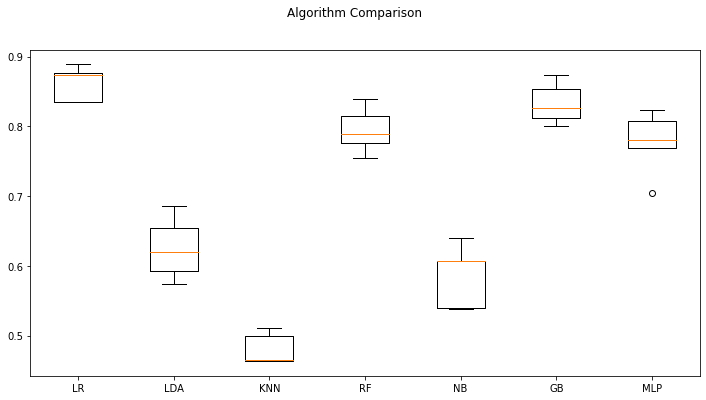

In [18]:
# boxplot algorithm comparison

plt.figure
d_boxplot = [results[i]['test_recall'] for i in np.arange(len(results))]
fig = plt.figure(figsize=(12,6))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(d_boxplot)
ax.set_xticklabels(names)
plt.show()

<a id="1.2"></a>
<h2 style="background-color:rgb(141, 153, 165);
           font-size:250%;
           color:white;
           text-align:center;
           margin: auto;
           padding: 10px;">Scaling</h2>

<a id='5.3.1'>
    <h2 style='font-size:210%;'>
        Comment on <code>StandardScaler()</code></h2></a>

I have seen many kaggle submissions that default to `StandardScaler()` without the consideration of the data distribution. However, `StandardScaler()` assumes that **data is normally distributed** within each of the features and scales them such that the distribution is centered around $0$ with a standard deviation of $1$. If data is not normally distributed, `StandardScaler()` is not the best scaler to use. Therefore, we will not be using `StandardScaler()` before normalizing the data.

[All About Feature Scaling, *Towards Data Science*](https://towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35)</br>
[Selectively Scale Numerical Input Variables for Machine Learning, *Machine Learning Mastery*](https://machinelearningmastery.com/selectively-scale-numerical-input-variables-for-machine-learning/)

<a id='5.3.1'>
    <h2 style='font-size:210%;'>
        Comment on <code>RobustScaler()</code></h2></a>

`RobustScaler()` is robust to outliers as it does not use the standard summary statistics such as the mean and standard deviation for scaling. Instead, `RobustScaler()` removes the median and scales the data using the **quantile range** (defaults to IQR). Although the scaler is less affected by the outliers, it does not remove the outliers.

[All About Feature Scaling, *Towards Data Science*](https://towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35)</br>
[Standardize or Normalize Examples in Python, *Medium*](https://medium.com/@rrfd/standardize-or-normalize-examples-in-python-e3f174b65dfc)

In [ ]:
scaler = RobustScaler()

<a id='4.2'>
    <h2 style='font-size:180%;'>
        Validation Set</h2></a>

In [ ]:
results_dic_scaler_robust = results_validation(models, scaler)

In [ ]:
result_scaler_robust = results_summary_df(results_dic_scaler_robust)

In [ ]:
result_scaler_robust

In [ ]:
df1 = result_scaler_robust.loc[:,['test_recall', 'train_recall']]
df1['scaler']=scaler

In [ ]:
df1 = df1.set_index('scaler', append=True).unstack(1).reorder_levels(order=[2, 0, 1], axis=1).reindex(results_baseline.index)

In [ ]:
df2 = results_baseline.loc[:,['test_recall', 'train_recall']]
df2['scaler']=MinMaxScaler()

In [ ]:
df2 = df2.set_index('scaler', append=True).unstack(1).reorder_levels(order=[2, 0, 1], axis=1).reindex(results_baseline.index)

In [ ]:
df3 = pd.concat([df1, df2], axis=1)

In [ ]:
df3

<a id='5.3.3'>
    <h2 style='font-size:150%;'>
        Quantile Transformer Scaler</h2></a>

`QuantileTransformer()` transforms the features to approximate a **uniform or a normal distribution** using **quantiles information**. Thus, the scaler spreads out the most frequent values as well as mitigate the effects of marginal outliers. This tranform is **non-linear**, so it may distort the features measured in the same scale but will help features measured in different scales more directly comparable. One can obtain a projection of the original values of a feature by using the cumulative distribution function. Another name for this scaler is the **Rank scaler**.

[All About Feature Scaling, *Towards Data Science*](https://towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35)

In [ ]:
scaler = QuantileTransformer()

<a id='4.2'>
    <h2 style='font-size:120%;'>
        Validation Set</h2></a>

In [ ]:
results_dic_scaler_quant_transf = results_validation(models, scaler)

In [ ]:
result_scaler_quant_transf = results_summary_df(results_dic_scaler_quant_transf)

In [ ]:
result_scaler_quant_transf

In [ ]:
df1 = result_scaler_quant_transf.loc[:,['test_recall', 'train_recall']]
df1['scaler']=scaler

In [ ]:
df1 = df1.set_index('scaler', append=True).unstack(1).reorder_levels(order=[2, 0, 1], axis=1).reindex(results_baseline.index)

In [ ]:
df3 = pd.concat([df3, df1], axis=1)

In [ ]:
df3

<a id='5.3.4'>
    <h2 style='font-size:150%;'>
        Power Transformer Scaler</h2></a>

The `PowerTransformer()` is a family of **parametric, monotonic** transformations that are applied to **make data more Gaussian-like**. This is useful for modeling issues related to the variability of a variable that is unequal across the range **(heteroscedasticity)** or situations where **normality is desired**.

The power transform finds the optimal scaling factor in **stabilizing variance and minimizing skewness through maximum likelihood estimation**. Currently, Sklearn implementation of PowerTransformer supports the Box-Cox transform and the Yeo-Johnson transform. The optimal parameter for stabilizing variance and minimizing skewness is estimated through maximum likelihood. Box-Cox requires input data to be strictly positive, while Yeo-Johnson supports both positive or negative data.

[Source: All About Feature Scaling](https://towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35)

In [ ]:
scaler = PowerTransformer()

<a id='4.2'>
    <h2 style='font-size:120%;'>
        Validation Set</h2></a>

In [ ]:
results_dic_scaler_pwr_transf = results_validation(models, scaler)

In [ ]:
result_scaler_pwr_transf = results_summary_df(results_dic_scaler_pwr_transf)

In [ ]:
result_scaler_pwr_transf

In [ ]:
df1 = result_scaler_pwr_transf.loc[:,['test_recall', 'train_recall']]
df1['scaler']=scaler

In [ ]:
df1 = df1.set_index('scaler', append=True).unstack(1).reorder_levels(order=[2, 0, 1], axis=1).reindex(results_baseline.index)

In [ ]:
df3 = pd.concat([df3, df1], axis=1)

In [ ]:
df3

Going with Quantile Transformer.

# PR-AUC & Recall

> However, ROC curves can present an overly optimistic view of an algorithm’s performance if there is a large skew in the class distribution. […] Precision-Recall (PR) curves, often used in Information Retrieval , have been cited as an alternative to ROC curves for tasks with a large skew in the class distribution.

— The Relationship Between Precision-Recall and ROC Curves, 2006.

<a id='4.2'>
    <h2 style='font-size:120%;'>
        Plot</h2></a>

Some promising candidates are: `RF`, `GB`, and `MLP` with the current pipeline. This ranking may change with the addition of feature selection, extraction, possibly another outlier treatment, and resampling.

In [ ]:
# plot the precision-recall curves
plt.figure(figsize=(12,9))
plt.style.use('seaborn-darkgrid')

no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], label='No Skill', 
         marker='', linewidth=4, alpha=0.7, color='yellow')


scaler = QuantileTransformer()

# fit a model
for i in np.arange(len(models)):
    model = models[i][1]
    pipeline = Pipeline([('s', scaler),('m',model)])
    pipeline.fit(x_train, y_train)
    
    # predict using test set
    y_hat = pipeline.predict(x_test) # predict class values
    y_hat_prob = pipeline.predict_proba(x_test)[:, 1] # predict probabilities; indexing added to retrieve just the probabilities for the positive class
    
    # print out the metrics for each model
    precision, recall, f2, support = precision_recall_fscore_support(y_test, y_hat)
    print('%s:   Precision: %.2f%%  Recall: %.2f%%  F-2: %.2f%%  Support: %.0f' % (
    models[i][0], precision[1]*100, recall[1]*100, f2[1]*100, support[1]))

    # compute precision-recall pairs for different probability thresholds & plot the results
    precision_t, recall_t, _ = precision_recall_curve(y_test, y_hat_prob)
    plt.plot(recall_t, precision_t, label=models[i][0],
            marker='', linewidth=4, alpha=0.7)
        
# axis labels
plt.xlabel('Recall', fontsize=18)
plt.ylabel('Precision', fontsize=18)

# show the legend
plt.legend(loc = (0.15,0.25), fontsize=14)
plt.title('2-Class Precision-Recall Curve',
         fontsize=18, fontweight=2)

# show the plot
plt.show()

In [ ]:
finish_normal = time.perf_counter()

In [ ]:
print(f'Finished in {round(finish_normal-start_normal, 2)} second(s) or {round((finish_normal-start_normal)/60, 2)} minute(s).')

Some promising candidates are: RF, GB, and MLP with the current pipelline. This ranking may change with the addition of feature selection / extraction and possibly another outlier treatment.